In [13]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [14]:
# Define image size and channels (assumes grayscale images)
image_size = 150
channels = 1  # Use 3 if RGB

# Prepare Data

In [15]:
training_data = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

In [16]:
validation_data = ImageDataGenerator(rescale=1.0/255)

train_gen = training_data.flow_from_directory(
    'Dataset_Split/train',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale' if channels == 1 else 'rgb'
)

Found 3476 images belonging to 5 classes.


In [19]:
val_data = ImageDataGenerator(
    rescale = 1.0 / 255,
    rotation_range= 10,
)

val_gen = val_data.flow_from_directory(
    'Dataset_Split/val',
    target_size=(image_size,image_size),
    batch_size=32,
    class_mode='sparse',
    color_mode = "grayscale",

)


Found 432 images belonging to 5 classes.


In [20]:
test_data = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10

)
test_gen = test_data.flow_from_directory(
    'Dataset_Split/test',
    target_size=(image_size, image_size),
    batch_size = 32,
    class_mode='sparse',
    color_mode = "grayscale",
)

Found 439 images belonging to 5 classes.


In [21]:
print(train_gen.class_indices)

{'Unknown': 0, 'cataract': 1, 'diabetic_retinopathy': 2, 'glaucoma': 3, 'normal': 4}


In [22]:
class_names = list(train_gen.class_indices.keys())
class_names

['Unknown', 'cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Build model

In [23]:
# Step 3: Load Pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size, image_size, channels),
    include_top=False,
    weights=None if channels == 1 else 'imagenet'
)


In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print(len(val_gen))
print(len(train_gen))

14
109


In [25]:
# Step 4: Build Full Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation='softmax')
])


In [26]:
# Step 5: Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# Step 6: Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stop]
)

c:\Users\DELL\OneDrive\Desktop\personal\personal_dl\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4306 - loss: 1.3675

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 5)

In [30]:
history = model.fit(
    train_gen,
    steps_per_epoch= len(train_gen),
    batch_size=16,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    verbose = 1,
    epochs = 10,
)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6079 - loss: 0.9461

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 5)

In [16]:
score = model.evaluate(test_gen)

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 609ms/step - accuracy: 0.7442 - loss: 0.7109


In [17]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0.5, 1.0, 'Loss vs Validation loss')

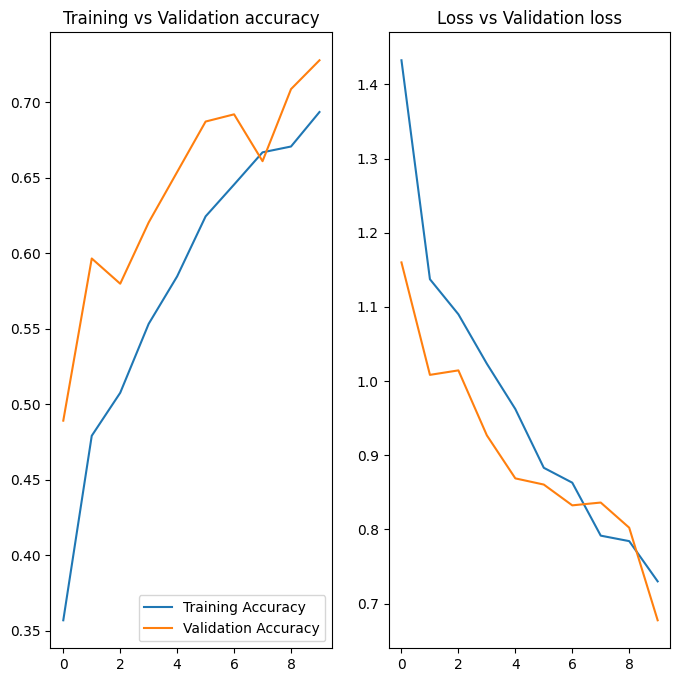

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 10
plt.figure(figsize= (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label = 'Training Accuracy')
plt.plot(range(epochs),val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label = 'Loss')
plt.plot(range(epochs),val_loss,label = 'Validation loss')
plt.title('Loss vs Validation loss')


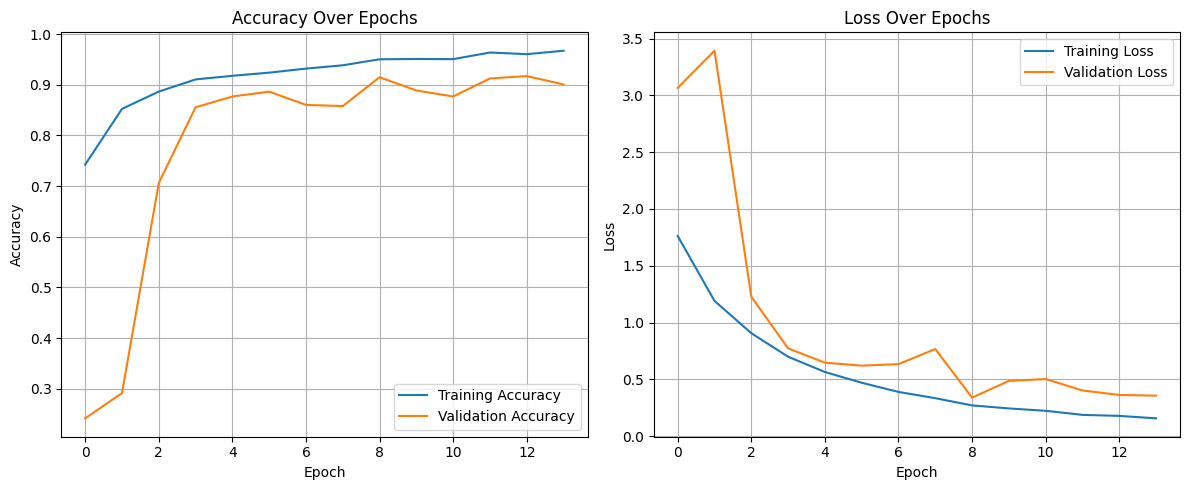

In [30]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


first image to predict
actual label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
predicted label: glaucoma


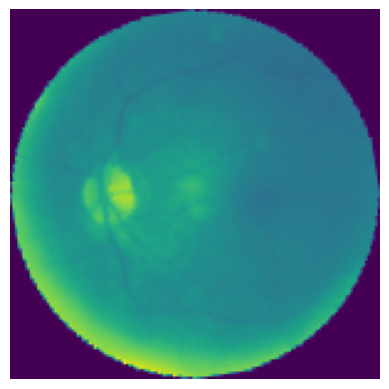

In [22]:
import numpy as np

for image_batch, label_batch in test_gen:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')
    
    break

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

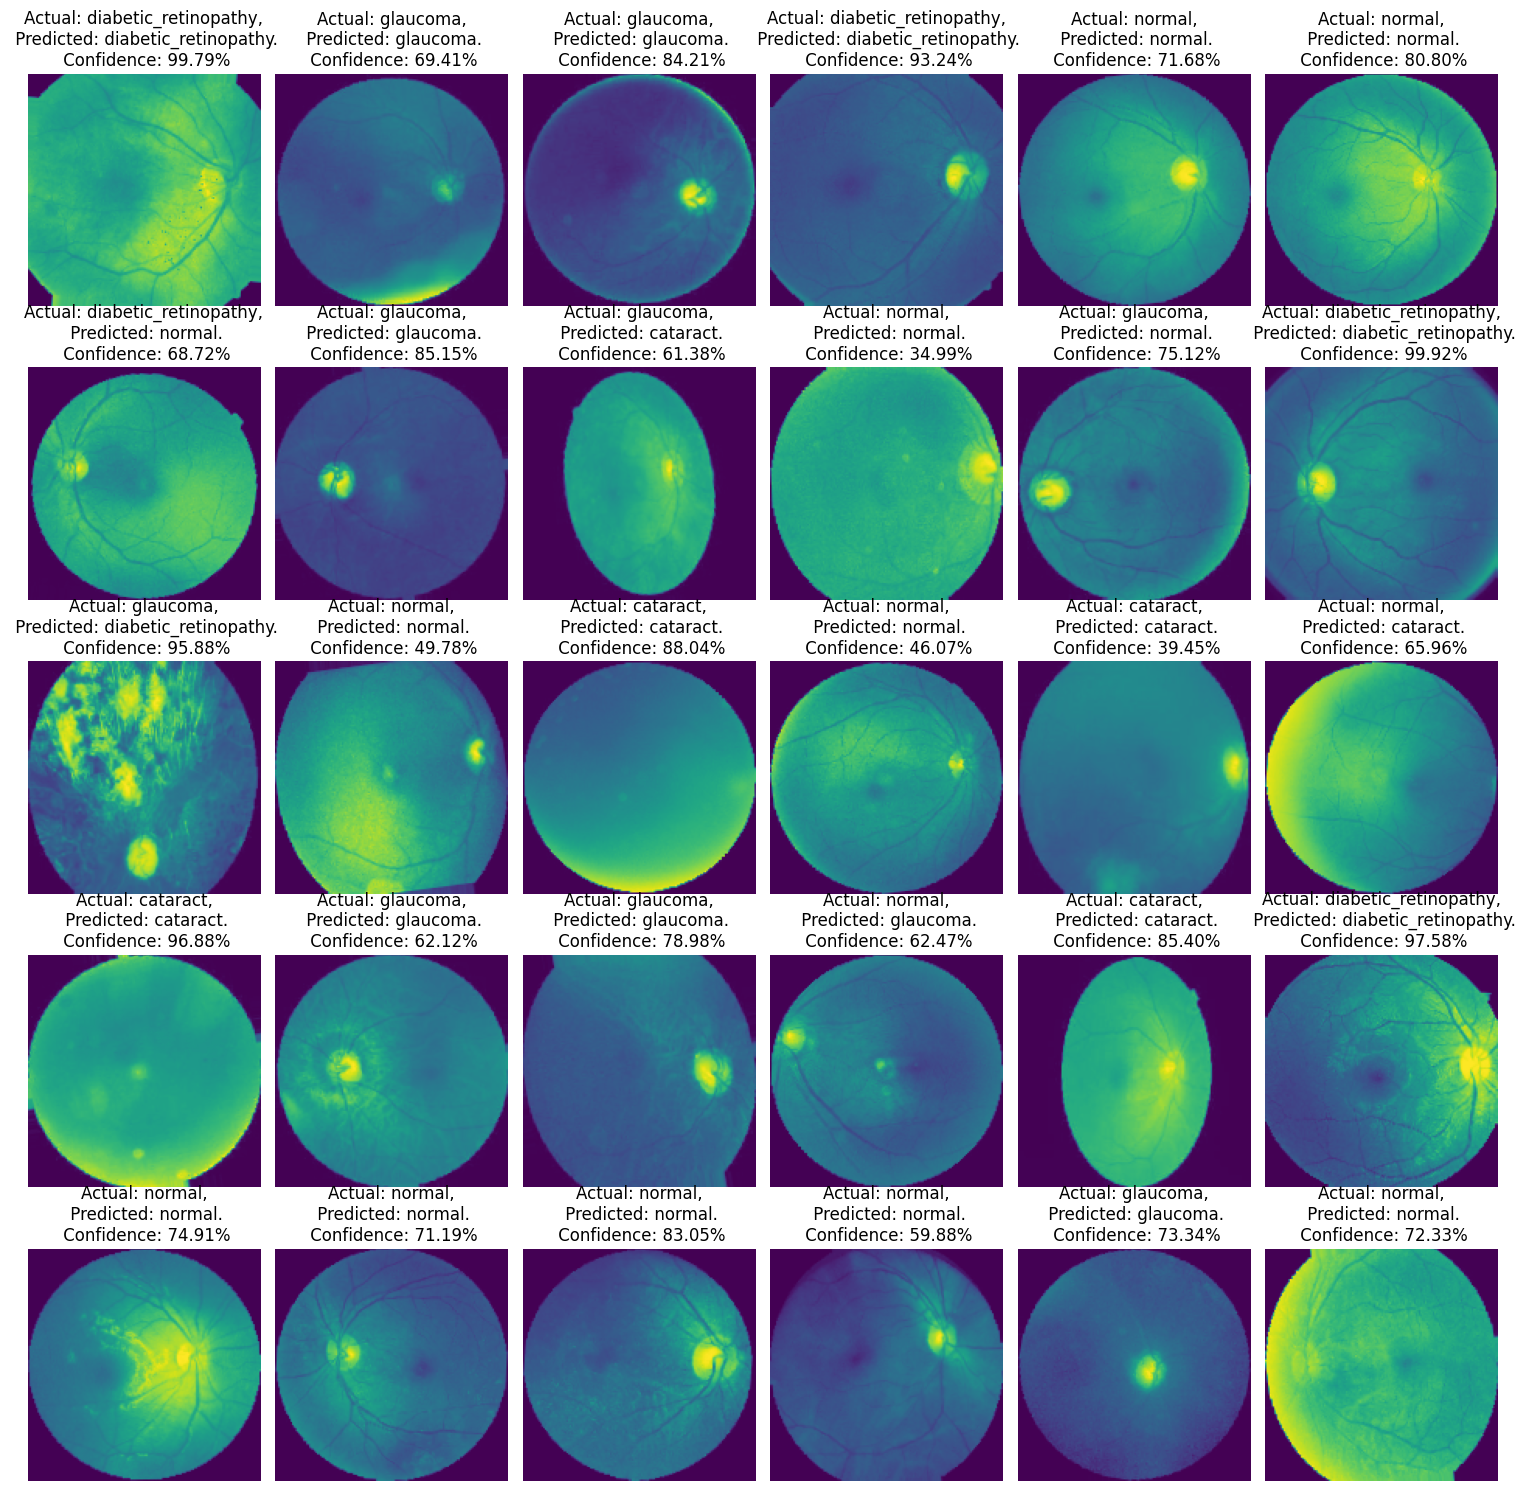

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_gen:
    for i in range(30):
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")
        plt.axis("off")
    break
plt.tight_layout() # Add this to prevent titles from overlapping
plt.show()


In [27]:
# model.save('Model_Handwriten.h5')
model.save('saved_model/Model_Handwriten.keras')

In [30]:
import tensorflow as tf

# 1. Load the .keras model
model = tf.keras.models.load_model("saved_model/Model_Handwriten.keras")

# 2. Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_lite = converter.convert()

# 3. Save the TFLite model
with open("handwritten.tflite", 'wb') as f:
    f.write(model_lite)

print("TensorFlow Lite model saved as handwritten.tflite")


INFO:tensorflow:Assets written to: C:\Users\SONAMS~1\AppData\Local\Temp\tmpoyxj6_c4\assets


INFO:tensorflow:Assets written to: C:\Users\SONAMS~1\AppData\Local\Temp\tmpoyxj6_c4\assets


Saved artifact at 'C:\Users\SONAMS~1\AppData\Local\Temp\tmpoyxj6_c4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 31), dtype=tf.float32, name=None)
Captures:
  2443716700560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716701712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716699600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716699024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716694992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716698448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716696528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716695952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716700368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2443716699216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  24

In [31]:
labels = '\n' .join(sorted(
    train_gen.class_indices.keys()))
with open('labels.txt', 'w', encoding='utf-8') as f:
    f.write(labels)

[INFO] evaluating the model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
                      precision    recall  f1-score   support

            cataract       0.27      0.31      0.29       105
diabetic_retinopathy       0.28      0.23      0.25       111
            glaucoma       0.22      0.23      0.22       102
              normal       0.31      0.31      0.31       108

            accuracy                           0.27       426
           macro avg       0.27      0.27      0.27       426
        weighted avg       0.27      0.27      0.27       426



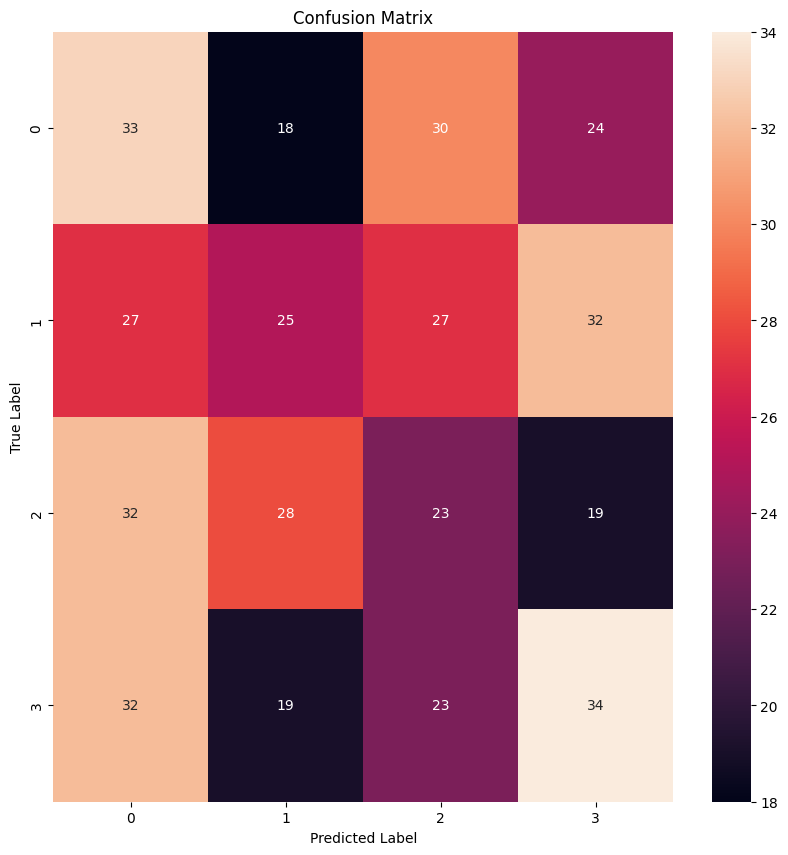

In [34]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
%matplotlib inline

# Reset the validation generator and evaluate the network after fine-tuning just the network head
print("[INFO] evaluating the model...")
test_gen.reset()
plt.figure(figsize=(10,10))
predIdxs = model.predict(test_gen, steps = len(test_gen))
predIdxs = np.argmax(predIdxs, axis=1)
matrix = confusion_matrix(test_gen.classes, predIdxs)
sns.heatmap(matrix, annot=True, cbar=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

print(classification_report(test_gen.classes, predIdxs, target_names=test_gen.class_indices.keys()))